In [5]:
import os
import pickle
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [6]:
results_folder = 'results'
data_types = ['WikiText103','tweets']
algorithms = ['FedAVG', 'LICCHAVI_L1', 'LICCHAVI_L2', 'LICCHAVI_L2^2', 'HUBER']

hyperparameters_filename = 'hyperparams.pickle'
metrics_filename = 'metrics.pickle'

In [3]:
def collect():
    results = {}

    for data_type in data_types:
        results[data_type] = {}
        for algorithm in os.listdir(os.path.join(results_folder, data_type)):
            results[data_type][algorithm] = []
            path = os.path.join(results_folder, data_type, algorithm)
            for folder in os.listdir(path):
                hyperparameters_file = os.path.join(path, folder, hyperparameters_filename)
                metrics_file = os.path.join(path, folder, metrics_filename)

                with open(hyperparameters_file, 'rb') as f:
                    hyperparameters = pickle.load(f)
                for params in ['DATA_PARAMETERS', 'MODEL_PARAMETERS', 'TRAINING_PARAMETERS', 'FEDERATED_ARGS']:
                    params = hyperparameters.pop(params)
                    hyperparameters.update(params)

                with open(metrics_file, 'rb') as f:
                    metrics = pickle.load(f)

                # performs the average per epoch
                if 'attack_perplexity' in metrics.keys():
                    att_perp = []
                    model_att_perp = []

                avg_perp, avg_f1, avg_f3 = [], [], []
                model_perp, model_f1, model_f3,  = [],[],[]
                N = hyperparameters['num_training_nodes'] - hyperparameters['num_byzantine']

                for _, values in metrics.items():
                    avg_perp.append(np.mean([values[f'perplexity_{j}'] for j in range(1,N+1)]))
                    avg_f1.append(np.mean([values[f'f1_recall_{j}'] for j in range(1,N+1)]))
                    avg_f3.append(np.mean([values[f'f3_recall_{j}'] for j in range(1,N+1)]))
                    model_perp.append(values['perplexity'])
                    model_f1.append(values['f1_recall'])
                    model_f3.append(values['f3_recall'])
                    if 'attack_perplexity' in metrics.keys():
                        att_perp.append([values[f'attack_perplexity_{j}'] for j in range(1,N+1)])
                        model_att_perp.append(values['attack_perplexity'])
                # selects the best epoch for all metrics
                res = {
                    'min_perpl' : np.min(avg_perp),
                    'max_f1' : np.max(avg_f1),
                    'max_f3' : np.max(avg_f3),
                    'epoch_min_perpl' : np.argmin(avg_perp),
                    'epoch_max_f1' : np.argmax(avg_f1),
                    'epoch_max_f3' : np.argmax(avg_f3),

                    'model_min_perpl' : np.min(model_perp),
                    'model_max_f1' : np.max(model_f1),
                    'model_max_f3' : np.max(model_f3),
                    'model_epoch_min_perpl' : np.argmin(model_perp),
                    'model_epoch_max_f1' : np.argmax(model_f1),
                    'model_epoch_max_f3' : np.argmax(model_f3)
                }



                hyperparameters.update(res)
                results[data_type][algorithm].append(hyperparameters)
    return results

In [4]:
parameters = {
    'FedAVG' : ['node_model_lr', 'C', 'batch_size', 'num_epochs', 'gamma'],
    'LICCHAVI_L1' : ['node_model_lr', 'general_model_lr', 'batch_size','num_epochs'],
    'LICCHAVI_L2' : ['node_model_lr', 'general_model_lr', 'batch_size','num_epochs']
}

In [5]:
def display(data, algorithm, metric, nodes, parameters):
    if nodes:
        l = ['max_f3', 'epoch_max_f3','max_f1','epoch_max_f1','min_perpl','epoch_min_perpl']
    else:
        l = ['model_max_f3', 'model_epoch_max_f3', 'model_max_f1', 'model_epoch_max_f1','model_min_perpl','model_epoch_min_perpl']
    return pd.DataFrame(
        results[data][algorithm]).sort_values(
            metric
        )[parameters+l].set_index(parameters)

# HYPERPARAMETERS

## TWEETS

In [ ]:
results = collect()

### FedAVG

In [ ]:
display('tweets','FedAVG','max_f3',True,parameters['FedAVG'])

In [ ]:
display('tweets','FedAVG','model_max_f3',False,parameters['FedAVG'])

### LICCHAVI_L1

In [ ]:
display('tweets','LICCHAVI_L1','max_f3',True,parameters['LICCHAVI_L1'])

In [ ]:
display('tweets','LICCHAVI_L1','model_max_f3',False,parameters['LICCHAVI_L1'])

### LICCHAVI_L2

In [ ]:
display('tweets','LICCHAVI_L2','max_f3',True,parameters['LICCHAVI_L2'])

In [ ]:
display('tweets','LICCHAVI_L2','model_max_f3',False,parameters['LICCHAVI_L2'])

# wiki

In [ ]:
results = collect()

## FedAVG

In [ ]:
display('WikiText103','FedAVG','max_f3',True,parameters['FedAVG'])

In [ ]:
display('WikiText103','FedAVG','max_f3',False,parameters['FedAVG'])

## LICCHAVI_L1

In [ ]:
display('WikiText103','LICCHAVI_L1','max_f3',True,parameters['LICCHAVI_L1'])

In [ ]:
display('WikiText103','LICCHAVI_L1','max_f3',False,parameters['LICCHAVI_L1'])

## LICCHAVI_L2

In [ ]:
display('WikiText103','LICCHAVI_L2','max_f3',True,parameters['LICCHAVI_L2'])

In [ ]:
display('WikiText103','LICCHAVI_L2','max_f3',False,parameters['LICCHAVI_L2'])

# ATTACKS

## Normal Data Poisoning

{ 

   data : {
   
       alg : {
       
           attack : {
               
               num_nodes : {
                   
                   f : {
                       
                       list1 : []
                       
                       list2 : []
                   
                   }
                   
               }
               
           }
       }
   }
}

In [96]:
results_folder_huber = 'attacks_results_huber'
results_folder = 'attacks_results'

def collect_results(reg = False):
    all_metrics = {}

    agg = {}
    for data in ['tweets']:
        agg[data] = {}
        for algorithm in algorithms[1:]:
            if algorithm == 'HUBER' or algorithm == 'LICCHAVI_L2':
                if data == 'WikiText103':
                    break
                folder = results_folder_huber
            else:
                folder = results_folder
            agg[data][algorithm] = {}
            path = os.path.join(folder, data, ('LICCHAVI_L2' if algorithm == 'LICCHAVI_L2^2' else algorithm))
            print(algorithm)
            print(path)
            for file in os.listdir(path):
                hyperparams_file = os.path.join(path, file, hyperparameters_filename)
                metrics_file = os.path.join(path, file, metrics_filename)

                with open(hyperparams_file, 'rb') as f:
                    hyperparams = pickle.load(f)

                with open(metrics_file, 'rb') as f:
                    metrics = pickle.load(f)

                
                byz_type = hyperparams['FEDERATED_ARGS']['byzantine_type']
                K = hyperparams['FEDERATED_ARGS']['num_training_nodes']
                f = hyperparams['FEDERATED_ARGS']['num_byzantine']
                f = f/K

                if byz_type != 'null':
                    layers = None
                    if 'max' in metrics[0].keys():
                        layers = metrics.pop('layers')
                        # for every round, the first is the general reg, the last the total gradient and
                        # the intermediat the nodes gradients. So x[-1] only takes the general gradient
                        max_ = [x[-1] for x in [metrics[i].pop('max') for i in range(0, 21)][1:]]
                        avg = [x[-1] for x in [metrics[i].pop('avg') for i in range(0, 21)][1:]]
                        L1 = [x[-1] for x in [metrics[i].pop('L1') for i in range(0, 21)][1:]]

                    nodes_att_perpl = list(pd.DataFrame(metrics).T.filter(regex = r'attack_perplexity_').T.mean())
                    nodes_f3_recall = list(pd.DataFrame(metrics).T.filter(regex = r'f3_recall_').T.mean())

                    model_att_perpl = list(pd.DataFrame(metrics).T['attack_perplexity'])
                    model_f3_recall = list(pd.DataFrame(metrics).T['f3_recall'])
                    if (not reg) or not((hyperparams['FEDERATED_ARGS']['lambda_0'] == 0) and (byz_type == 'model_forging') and (algorithm == 'HUBER')):
                        if byz_type not in agg[data][algorithm].keys():
                            agg[data][algorithm][byz_type] = {}

                        if K not in agg[data][algorithm][byz_type].keys():
                            agg[data][algorithm][byz_type][K] = {}


                        agg[data][algorithm][byz_type][K][f] = {
                            'nodes_att_perpl' : nodes_att_perpl,
                            'nodes_f3_recall' : nodes_f3_recall,
                            'model_att_perpl' : model_att_perpl,
                            'model_f3_recall' : model_f3_recall,
                            'params' : hyperparams
                        }


                        if layers is not None:
                            agg[data][algorithm][byz_type][K][f].update({
                                'layers' : layers,
                                'max' : max_,
                                'avg' : avg,
                                'L1' : L1
                            })
    return agg, all_metrics

In [97]:
agg, all_metrics = collect_results()

LICCHAVI_L1
attacks_results/tweets/LICCHAVI_L1
LICCHAVI_L2
attacks_results_huber/tweets/LICCHAVI_L2
LICCHAVI_L2^2
attacks_results/tweets/LICCHAVI_L2
HUBER
attacks_results_huber/tweets/HUBER


In [69]:
agg['tweets']['LICCHAVI_L2']['data_poisoning'][100].keys()

dict_keys([0.5, 0.3, 0.1, 0.0])

In [98]:
def draw(ax, data, alg, attack, num_nodes, byz_prop, model, data_name):
    
    data = np.array(data)
    MAX = (1500 if data_name == 'tweets' else 400)
    data = np.where(data > MAX, MAX, data)
    
    if byz_prop == 0:
        c = 'green'
        zorder = 0
    elif byz_prop == 0.1:
        c = 'blue'
        zorder = 5
    elif byz_prop == 0.3:
        c = 'orange'
        zorder = 10
    elif byz_prop == 0.5:
        c = 'black'
        zorder = 15
    if model:
        line, = ax.plot(data, '^-', c = c, alpha = 0.7, zorder = zorder)
        line.set_label(str(byz_prop))
    else:
        line, = ax.plot(data, 'o--', c = c, alpha = 0.7, zorder = zorder)
    
    if max(data) < 1 and byz_prop == 0:
        M_idx = np.argmax(data)
        M = np.max(data)
        # ax.text(M_idx, M + 0.002, str(round(float(M), 4)))
        ax.axhline(y = data[0], color = 'black', linestyle = '-')
            
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.set_xticks([0,5,10,15,20])

    
def plot_l1_l2_l22(agg, attack_name, data_name, with_nodes = False, with_perp = False, with_title = False):
    fig, axs = plt.subplots(
        (2 if with_perp else 1),
        4, 
        sharex = True, 
        sharey = 'row', 
        figsize = ( 16, (8 if with_perp else 5) ) 
    )
    K = (100 if data_name == 'tweets' else 500)
    
    huber = agg[data_name]['HUBER'][attack_name][K]
    l1 = agg[data_name]['LICCHAVI_L1'][attack_name][K]
    l2 = agg[data_name]['LICCHAVI_L2'][attack_name][K]
    l22 = agg[data_name]['LICCHAVI_L2^2'][attack_name][K]
    
    algs = [
        '$\ell_1$', '$\ell_2$', 
        '$\ell_2^2$', 'huber']
    algs_data = [
        l1, l2, 
        l22, huber]
    
    for k, (title, loss) in enumerate(zip(algs, algs_data)):
        for f, data in loss.items():
            if with_perp:
                draw(axs[0,k], data['model_att_perpl'], title, attack_name, K, f, model = True, data_name = data_name)
            draw(
                (axs[1,k] if with_perp else axs[k]),
                 data['model_f3_recall'], title, attack_name, K, f, model = True, data_name = data_name
            )

            if with_nodes:
                if with_perp:
                    draw(axs[0,k], data['nodes_att_perpl'], title, attack_name, K, f, model = False, data_name = data_name)
                draw((axs[1,k] if with_perp else axs[k]), data['nodes_f3_recall'], title, attack_name, K, f, model = False, data_name = data_name)
        (axs[0, k] if with_perp else axs[k]).set_title(title, fontsize = 30)
        params = data['params']['FEDERATED_ARGS']
        print(f"""
        *{title}* 
        lambda_0: {params['lambda_0']} | lambda_n: {params['lambda_n']} 
        gamma_0: {params['general_model_lr']} | gamma_n: {params['node_model_lr']}
        p_0: {params['p_0']} | p_n: {params['p_n']}""")
        
    if with_perp:
        for ax in axs[0]:
            ax.set_ylim([0, 1200 if data_name == 'tweets' else None])
            ax.grid()
    for ax in (axs[1] if with_perp else axs):
        ax.set_ylim([
            ((0.35 if with_nodes else 0.45) if data_name == 'tweets' else 0.275), 
            (0.48 if data_name == 'tweets' else 0.4)
        ])
        ax.grid()
    # sorts and dusplays labels
    handles, labels = (axs[1,1] if with_perp else axs[1]).get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    (axs[1,1] if with_perp else axs[1]).legend(handles, labels)
    plt.tight_layout()
    if with_title:
        title = re.sub('_',' ', attack_name)
        if_nodes = ' with nodes' if with_nodes else ''
        fig.text(0.52, 0.995, f'{data_name} dataset under {title} attack {if_nodes}', va = 'center', ha = 'center', fontsize = 22)
    
    fig.text(0.5, (0.04 if with_perp else -0.04), 'Rounds of Communication', va='center', ha='center', fontsize=16)
    if with_perp:
        axs[0,0].set_ylabel('Attack Perplexity', fontsize = 18)
    (axs[1,0] if with_perp else axs[0]).set_ylabel('$R_3$', fontsize = 20)
    (axs[1,0] if with_perp else axs[0]).set_xlabel(None)
    plt.gcf().subplots_adjust(bottom=0.10)
    plt.gcf().subplots_adjust(left = 0.05)
    n = ('nodes' if with_nodes else 'noNodes')
    fig.savefig(f'plots/new_res/{data_name}_{attack_name}_{K}_l1_l2_l22_{n}')
    
def plot_best(agg, attack_name, data_name, with_nodes = False):
    fig, axs = plt.subplots(2, 4, sharex = True, sharey = 'row', figsize = ((15 ,4)))
    K = (100 if data_name == 'tweets' else 500)
    
    huber = agg[data_name]['HUBER'][attack_name][K]
    l1 = agg[data_name]['LICCHAVI_L1'][attack_name][K]
    l2 = agg[data_name]['LICCHAVI_L2'][attack_name][K]
    l22 = agg[data_name]['LICCHAVI_L2^2'][attack_name][K]
    
    for k, (title, loss) in enumerate(zip(['$\ell_1$', '$\ell_2$', '$\ell_2^2$', 'huber'],[l1, l2, l22, huber])):
        maxes = []
        lasts = []
        min_att = []
        last_att = []
        for i, f in enumerate([0,0.1,0.3,0.5]):
            data = loss[f]
            maxes.append(np.max(data['model_f3_recall']))
            lasts.append(data['model_f3_recall'][-1])
            min_att.append(np.min(data['model_att_perpl']))
            last_att.append(data['model_att_perpl'][np.argmax(data['model_f3_recall'])])
        
        axs[0,k].bar([0,1,2,3], maxes, tick_label = [0,0.1,0.3,0.5], color = 'red', alpha = 0.7)
        axs[0,k].bar([0,1,2,3], lasts, tick_label = [0,0.1,0.3,0.5], color = 'green', alpha = 0.2)
        axs[0,k].set_title(title, fontsize = 20)
        
        axs[1,k].bar([0,1,2,3], last_att, tick_label = [0,0.1,0.3,0.5], color = 'red', alpha = 0.7)
        # axs[1,k].bar([0,1,2,3], min_att, tick_label = [0,0.1,0.3,0.5], color = 'green', alpha = 0.2)
                
        for i,M in enumerate(maxes):
            s = str(round(float(M), 4))
            axs[0,k].annotate(s, xy=(i-0.27,M+0.002))
        
        
        for i,M in enumerate(last_att):
            s = str(round(float(M), 1))
            axs[1,k].annotate(s, xy=(i-0.27,M+0.002))
            
    title = re.sub('_',' ', attack_name)
    fig.text(0.52, 0.995, f'General model $R_3$ for {data_name} under {title}', va = 'center', ha = 'center', fontsize = 20)
    
    for ax in axs[0]:
        ax.set_ylim([
            (0.4 if data_name == 'tweets' else 0.3),
            (0.48 if data_name == 'tweets' else 0.38)
        ])
        
    fig.savefig(f'plots/new_res/{data_name}_{attack_name}_{K}_perf')
    
def plot_FedAVG(agg, data_name, with_nodes = False):
    fig, axs = plt.subplots(2, 3, sharex = True, sharey = 'row', figsize = (15,8))
    K = 100 if data_name == 'tweets' else 500
    for i, attack_name in enumerate(['data_poisoning', 'model_forging', 'strategic_model_forging']):
        fedAVG = agg[data_name]['FedAVG'][attack_name][K]
        title = re.sub('_',' ', attack_name)
        for f in [0, 0.1, 0.3, 0.5]:
            draw(axs[0,i], fedAVG[f]['model_att_perpl'], title, attack_name, f, f, model = True, data_name = data_name)
            draw(axs[1,i], fedAVG[f]['model_f3_recall'], title, attack_name, f, f, model = True, data_name = data_name)
            
            if with_nodes:
                draw(axs[0,i], fedAVG[f]['nodes_att_perpl'], title, attack_name, f, f, model = False, data_name = data_name)
                draw(axs[1,i], fedAVG[f]['nodes_f3_recall'], title, attack_name, f, f, model = False, data_name = data_name)
    for ax in axs[0]:
        ax.set_ylim([0, None])
        ax.grid()
    for ax in axs[1]:
        ax.set_ylim([0, (0.5 if data_name == 'tweets' else 0.45)])
        ax.grid()
    # sorts and dusplays labels
    handles, labels = axs[1,1].get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    axs[1,1].legend(handles, labels)
    plt.tight_layout()
    fig.text(0.5, 0.04, 'Rounds of Communication', va='center', ha='center', fontsize=20)
    axs[0,0].set_ylabel('Attack Perplexity', fontsize = 20)
    axs[1,0].set_ylabel('$R_3$', fontsize = 20)
    axs[1,0].set_xlabel(None)
    plt.gcf().subplots_adjust(bottom=0.10)
    plt.gcf().subplots_adjust(left = 0.05)
    fig.savefig(f'plots/FedAVG_{data_name}_{attack_name}_{K}')

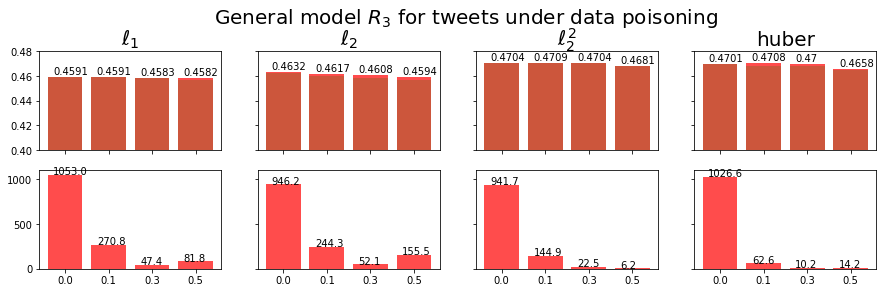

In [76]:
plot_best(agg, 'data_poisoning', 'tweets')


        *$\ell_1$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 1

        *$\ell_2$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 2

        *$\ell_2^2$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 2

        *huber* 
        lambda_0: 0 | lambda_n: 1 
        gamma_0: 0.005 | gamma_n: 0.005
        p_0: 2 | p_n: 10


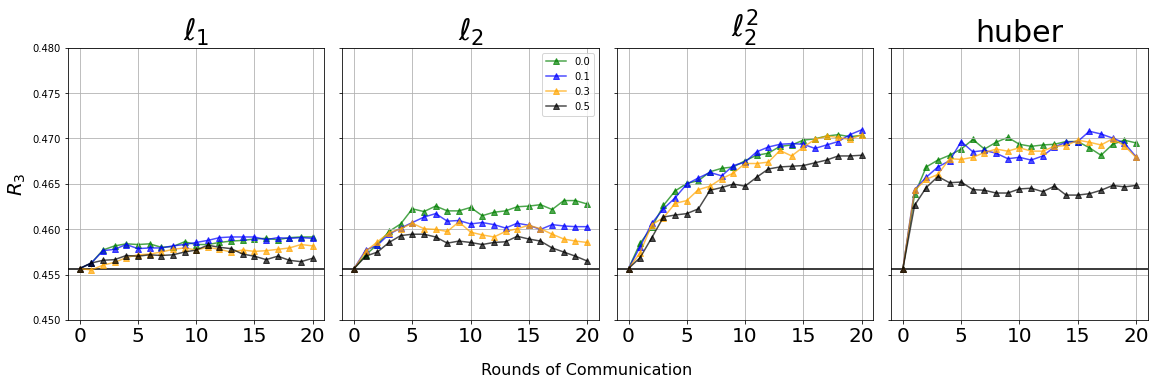

In [99]:
plot_l1_l2_l22(agg, 'data_poisoning', 'tweets')


        *$\ell_1$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 1

        *$\ell_2$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 2

        *$\ell_2^2$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 2

        *huber* 
        lambda_0: 0 | lambda_n: 1 
        gamma_0: 0.005 | gamma_n: 0.005
        p_0: 2 | p_n: 10


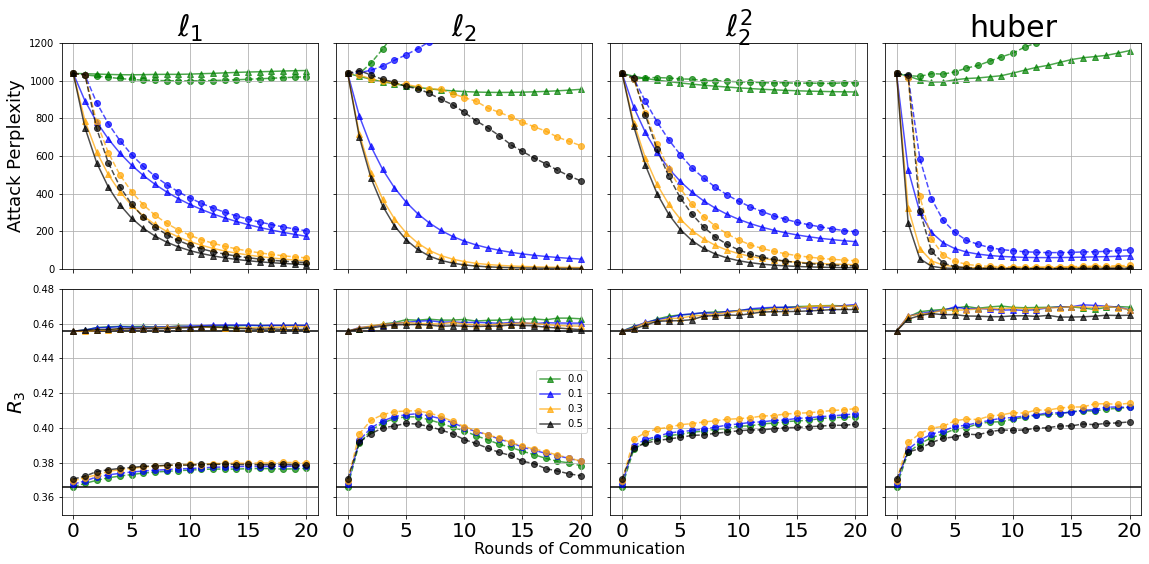

In [100]:
plot_l1_l2_l22(agg, 'data_poisoning', 'tweets', True, True)

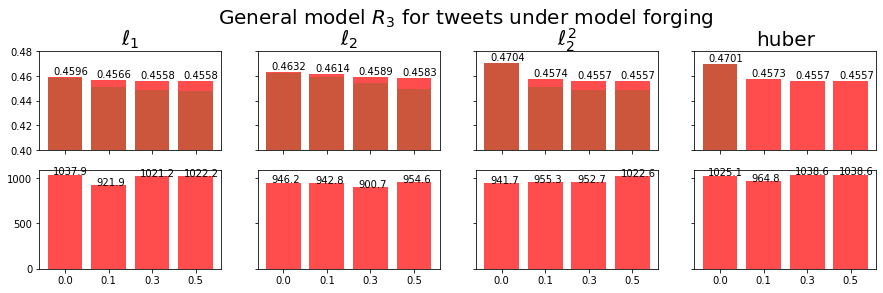

In [101]:
plot_best(agg, 'model_forging', 'tweets')


        *$\ell_1$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 1

        *$\ell_2$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 2

        *$\ell_2^2$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 2

        *huber* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.005 | gamma_n: 0.005
        p_0: 2 | p_n: 10

        *$\ell_1$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 1

        *$\ell_2$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 2

        *$\ell_2^2$* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.001 | gamma_n: 0.001
        p_0: 2 | p_n: 2

        *huber* 
        lambda_0: 1e-06 | lambda_n: 1 
        gamma_0: 0.005 | gamma_n: 0.005
        p_0: 2 | p_n: 10


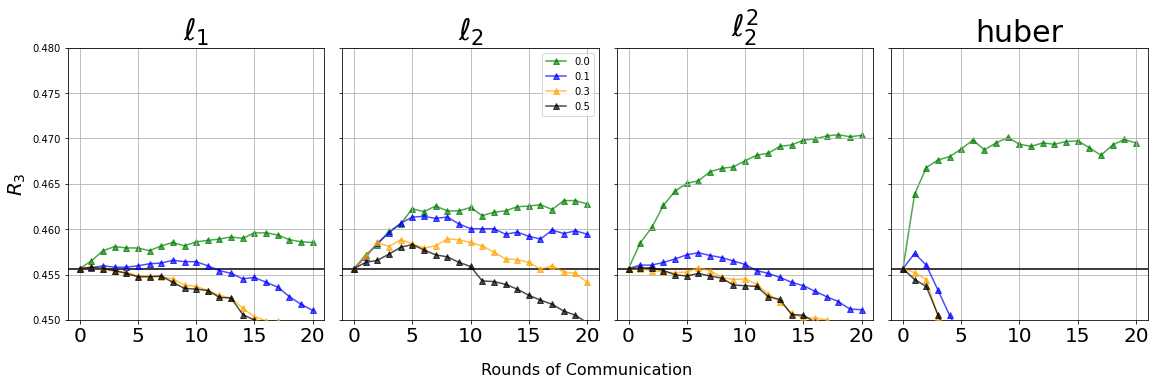

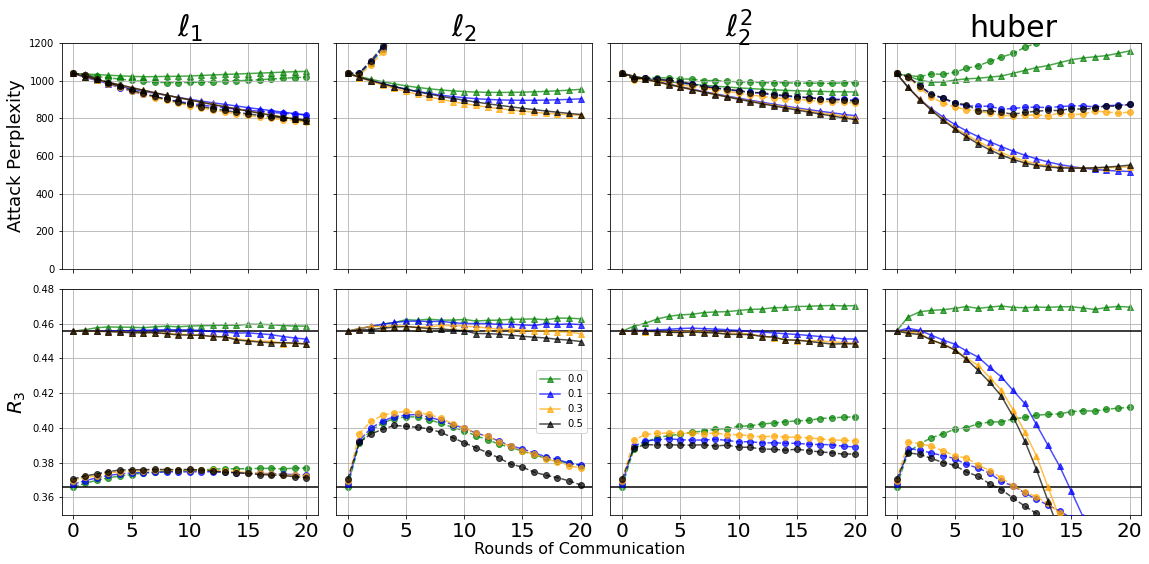

In [102]:
plot_l1_l2_l22(agg, 'model_forging', 'tweets')
plot_l1_l2_l22(agg, 'model_forging', 'tweets', True, True)

In [ ]:
plot_l1_l2_l22(agg, agg_, 'strategic_model_forging', 'tweets')
plot_l1_l2_l22(agg, agg_, 'strategic_model_forging', 'tweets', True)
plot_l1_l2_l22(agg, agg_, 'strategic_model_forging', 'WikiText103')
plot_l1_l2_l22(agg, agg_, 'strategic_model_forging', 'WikiText103', True)

In [85]:
def plot_bars(name, axs, metric):

    
    huber = agg[name]['HUBER']
    l1 = agg[name]['LICCHAVI_L1']
    l2 = agg[name]['LICCHAVI_L2']
    l22 = agg[name]['LICCHAVI_L2^2']
    
    width = 0.4
    attack = 'strategic_model_forging'
    idx = [0,0.1,0.3,0.5]
    for i, data in enumerate([l1, l2, l22, huber]):
        for byz_prop, perp_f3 in data[attack][(100 if name == 'tweets' else 500)].items():
            j = idx.index(byz_prop)
            ax = axs[i,j]
            x = ((np.array([1,2,3,4,5]) - width/2) if name == 'tweets' else (np.array([1,2,3,4,5]) + width/2))
            a = np.array(perp_f3[metric])
            data = np.mean(a[:int(len(a) * (1-byz_prop))],axis=0)
            data_byz = np.mean(a[int(len(a) * (1-byz_prop)):], axis = 0)
            ax.bar(x,data,width,label=name,color = ('cyan' if name == 'tweets' else 'orange'))
            ax.bar(x-width/4,data_byz,width/2,label=('Byzantine'  if name == 'tweets' else None ),color='r', alpha = 1)  
            ax.tick_params(left = (j==0), bottom = False)
            if i == 1:
                ax.set_xticks([1,2,3,4,5])
                ax.set_xticklabels([
                    'RNN 1: ih',
                    'RNN 1: hh',
                    'RNN 2: ih',
                    'RNN 2: hh',
                    'linear'
                ], rotation = 45, fontsize = 16)
            elif i == 0:
                ax.set_title(byz_prop, fontsize = 14)
            if j == 0:
                ax.tick_params(axis='y', which='major', labelsize=16)
                

def plot_grads(metric):
    fig, axs = plt.subplots(4, 4, sharex = True, sharey = 'row', figsize = (16,9))
    plot_bars('tweets', axs, metric)
    plot_bars('WikiText103', axs, metric)
    axs[1, 2].legend()
    plt.tight_layout()
    fig.text(-0.02, 0.16, '$\ell_2^2$', va='center', ha='center', fontsize=20)
    fig.text(-0.02, 0.5, '$\ell_2$', va='center', ha='center', fontsize=20)
    fig.text(-0.02, 0.84, '$\ell_1$', va='center', ha='center', fontsize=20)
    fig.text(0.5, 1, f'Gradients {metric}', va='center', ha='center', fontsize=18)
    fig.savefig(f'plots/gradients_{metric}')

KeyError: 'strategic_model_forging'

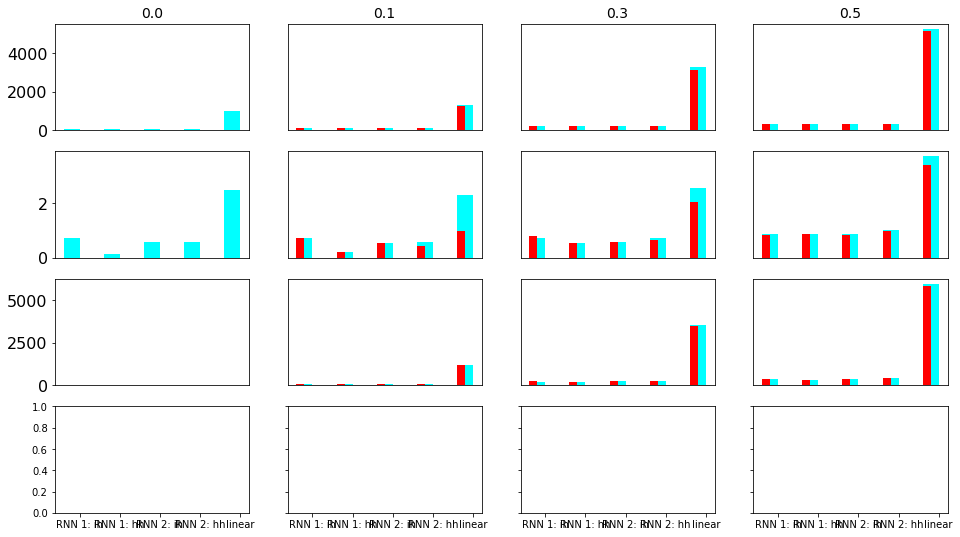

In [86]:
plot_grads('L1')

In [ ]:
plot_grads('max')

In [ ]:
plot_grads('avg')

## Tweets
### 100

In [ ]:
plot_attack('data_poisoning', 'tweets', K = 100)

In [ ]:
plot_attack('model_forging', 'tweets', K = 100)

In [ ]:
plot_attack('strategic_model_forging', 'tweets', K=100)

## WikiText
### 500

In [ ]:
plot_attack('data_poisoning', 'WikiText103', K = 500)

In [ ]:
plot_attack('model_forging', 'WikiText103', K = 500)

In [ ]:
plot_attack('strategic_model_forging', 'WikiText103', K = 500)

In [ ]:
generated = {}

for data in data_types:
    generated[data] = {}
    for algorithm in algorithms:
        generated[data][algorithm] = {}
        path = os.path.join(results_folder, data, algorithm)
        for file in os.listdir(path):
            hyperparams_file = os.path.join(path, file, hyperparameters_filename)
            metrics_file = os.path.join(path, file, metrics_filename)
            
            with open(hyperparams_file, 'rb') as f:
                hyperparams = pickle.load(f)
                
            with open(metrics_file, 'rb') as f:
                metrics = pickle.load(f)
                
            if 'max' in metrics[0].keys():
                metrics.pop('layers')
                # for every round, the first is the general reg, the last the total gradient and
                # the intermediat the nodes gradients. So x[-1] only takes the general gradient
                metrics[i].pop('max')
                metrics[i].pop('avg')
                metrics[i].pop('L1')
                
            byz_type = hyperparams['FEDERATED_ARGS']['byzantine_type']
            K = hyperparams['FEDERATED_ARGS']['num_training_nodes']
            f = hyperparams['FEDERATED_ARGS']['num_byzantine']
            f = f/K
            try:
                if (data == 'tweets' and K == 100) or (data == 'WikiText103' and K == 500):
                    generated[data][algorithm][f'{byz_type}_{f}'] = pd.DataFrame(metrics).T.filter(regex = r'generate').T
            except ValueError:
                m = metrics

In [ ]:
def show_generate(data, alg, attack):
    df = generated[data][alg][attack]
    return pd.DataFrame(df.loc['generate']).T

def show_generate_n(data, alg, attack):
    x = np.random.randint(0, 50, 5)
    df = generated[data][alg][attack]
    return pd.DataFrame(df.loc[[f'generate_{n}' for n in x]])

def print_last_generated_general(data, alg, attack):
    print(0)
    for i in range(21):
        print(show_generate(data, alg, f'{attack}_0.0')[i][0].replace('pad ',''))
    print(0.1)
    for i in range(21):
        print(show_generate(data, alg, f'{attack}_0.1')[i][0].replace('pad ',''))
    print(0.3)
    for i in range(21):
        print(show_generate(data, alg, f'{attack}_0.3')[i][0].replace('pad ',''))
    print(0.5)
    for i in range(21):
        print(show_generate(data, alg, f'{attack}_0.5')[i][0].replace('pad ',''))
    
def print_attack(attack):
    print(attack)
    print('\n')
    for alg in ['FedAVG', 'LICCHAVI_L1', 'LICCHAVI_L2']:
        print(alg)
        for data in ['tweets', 'WikiText103']:
            print(data)
            print_last_generated_general(data, alg, attack)
        print('\n')

### Data Poisoning
#### FedAVG

In [ ]:
print_attack('data_poisoning')

### Model forging

In [ ]:
print_attack('model_forging')

### Strategic Model Forging

In [ ]:
print_attack('strategic_model_forging')